In [79]:
import numpy as np
import tensorflow as tf
import gpflow
import matplotlib.pyplot as plt
np.random.seed(1976)
tf.random.set_seed(1976)

In [80]:
from math import sin

In [81]:
def fe(x):
    return(6*x-2)*(6*x-2)*tf.sin(12*x-4)
def fc(x):
    return(1/2*fe(x)+10*(x-1/2)-5)

In [82]:
## We deien an observer for each fidelity level
from trieste.data import Dataset
OBJECTIVE = "OBJECTIVE"
def observer_e(query_points_e):
    return {
        OBJECTIVE: Dataset(query_points_e, fe(query_points_e))
    }

In [83]:
def observer_c(query_points_c ):
    return {
        OBJECTIVE: Dataset(query_points_c, fc(query_points_c))
    }

In [84]:
num_initial_points_e=4
num_initial_points_c=11

In [85]:
X_c=np.array([[0],[0.1],[0.2],[0.3],[0.4],[0.5],[0.6],[0.7],[0.8],[0.9],[1]])
X_e=np.array([[0],[0.4],[0.6],[1]])


In [86]:
initial_data_c = observer_c(X_c)
initial_data_e = observer_e(X_e)


In [87]:
List=np.arange(0,1,0.001)

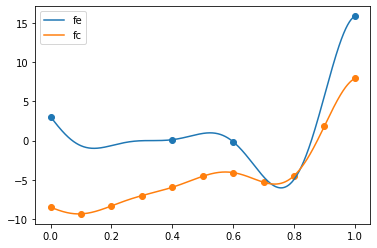

In [89]:
plt.plot(List,fe(List), label='fe')
plt.plot(List,fc(List), label='fc')
plt.scatter(initial_data_e[OBJECTIVE].query_points,initial_data_e[OBJECTIVE].observations)
plt.scatter(initial_data_c[OBJECTIVE].query_points,initial_data_c[OBJECTIVE].observations)
plt.legend()

In [90]:
## building the coarse model
k=gpflow.kernels.RBF(1)           ## the squared exponential kernel 
theta2=gpflow.kernels.Constant()
k_c=k+theta2 
k_c


<gpflow.kernels.base.Sum object at 0x7f7d04219480>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [ ]:
### THETA={l,sigma_square, theta2} are the kernel hyperparameters that we need to determine
### one way to do that is by maximizing the log-likelihood or minimizing the loss function 

In [92]:
## calculating the mean-function over the observations 
mean=tf.math.reduce_mean(initial_data_c[OBJECTIVE].observations[:])
mean_function=gpflow.mean_functions.Constant(mean)

model_c=gpflow.models.GPR((initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:]),k_c,mean_function)

In [93]:
## finding the best hyperparameters


optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model_c.training_loss,variables=model_c.trainable_variables,options=dict(disp=True, maxiter=100),)
 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58699D+01    |proj g|=  3.51385D+01

At iterate    1    f=  6.37722D+01    |proj g|=  1.49822D+01

At iterate    2    f=  4.84895D+01    |proj g|=  7.25520D+00

At iterate    3    f=  4.21989D+01    |proj g|=  4.14560D+00

At iterate    4    f=  3.64883D+01    |proj g|=  2.06134D+00

At iterate    5    f=  3.44732D+01    |proj g|=  4.15653D+00

At iterate    6    f=  3.27698D+01    |proj g|=  1.56292D+00

At iterate    7    f=  3.17637D+01    |proj g|=  6.97281D-01

At iterate    8    f=  3.09849D+01    |proj g|=  4.78504D-01

At iterate    9    f=  3.02301D+01    |proj g|=  2.55361D-01

At iterate   10    f=  2.97226D+01    |proj g|=  2.75742D-01

At iterate   11    f=  2.91927D+01    |proj g|=  3.18290D-01

At iterate   12    f=  2.09947D+01    |proj g|=  1.01015D+01

At iterate   13    f=  2.0

 This problem is unconstrained.


      fun: 20.470096032000797
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.10266887e-04, -5.33837544e-06,  2.66287586e-07,  1.89136508e-05,
        2.97128161e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 74
      nit: 58
     njev: 74
   status: 0
  success: True
        x: array([ -1.63156041,  33.93131751, -12.15142486,  -7.23213718,
        -3.38491034])


At iterate   58    f=  2.04701D+01    |proj g|=  8.10267D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     58     74      1     0     0   8.103D-04   2.047D+01
  F =   20.470096032000797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [94]:
model_c

<gpflow.models.gpr.GPR object at 0x7f7d0432a4d0>
╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.mean_function.c                │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -3.38491     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 33.9313      │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  0.178668    │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  5.28083e-06 │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.likelihood.variance            │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │  0.000723713 │
╘════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧══════════════╛

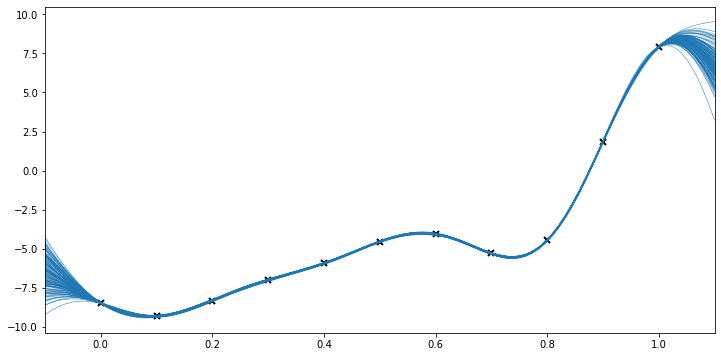

In [96]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_c, var_c = model_c.predict_f(xx)

## generate 100 samples from posterior
samples = model_c.predict_f_samples(xx, 100) # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_c, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);



In [34]:
## we fix the trained hyperparameters of the lowest model
gpflow.set_trainable(k_c.kernels, False)


<gpflow.kernels.base.Sum object at 0x7f7d08caa200>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [97]:
## fine model
## we will generate a gaussian process for the highest fidely model to see the curve 
k=gpflow.kernels.RBF()
theta=gpflow.kernels.Constant()
k_e=k+theta
k_e

<gpflow.kernels.base.Sum object at 0x7f7d041abc70>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │       1 │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧═════════╛

In [100]:
mean=tf.math.reduce_mean(initial_data_e[OBJECTIVE].observations[:])
mean_function=gpflow.mean_functions.Constant(mean)
model_e=gpflow.models.GPR((initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:]),k_e,mean_function)
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model_e.training_loss,variables=model_e.trainable_variables,options=dict(disp=True, maxiter=100),)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29104D+01    |proj g|=  8.77614D-02

At iterate    1    f=  1.29040D+01    |proj g|=  9.79346D-02

At iterate    2    f=  1.28802D+01    |proj g|=  5.79967D-02

At iterate    3    f=  1.28570D+01    |proj g|=  6.86381D-02

At iterate    4    f=  1.28537D+01    |proj g|=  2.62238D-02

At iterate    5    f=  1.28535D+01    |proj g|=  9.84652D-03

At iterate    6    f=  1.28532D+01    |proj g|=  9.28267D-03

At iterate    7    f=  1.28525D+01    |proj g|=  3.45527D-02

At iterate    8    f=  1.28508D+01    |proj g|=  7.08127D-02

At iterate    9    f=  1.28478D+01    |proj g|=  9.62179D-02

At iterate   10    f=  1.28437D+01    |proj g|=  7.23744D-02

At iterate   11    f=  1.28414D+01    |proj g|=  1.99064D-02

At iterate   12    f=  1.28410D+01    |proj g|=  4.54099D-03

At iterate   13    f=  1.2

 This problem is unconstrained.


      fun: 12.840426265330823
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.09147958e-006,  4.60494995e-007,  2.10017770e-006,
        2.04223412e-112,  2.90573213e-006])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 40
      nit: 33
     njev: 40
   status: 0
  success: True
        x: array([  -1.46481775,   41.55880238,   -9.70244298, -252.97636394,
          6.00744643])


At iterate   33    f=  1.28404D+01    |proj g|=  9.09148D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     40      1     0     0   9.091D-06   1.284D+01
  F =   12.840426265330823     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


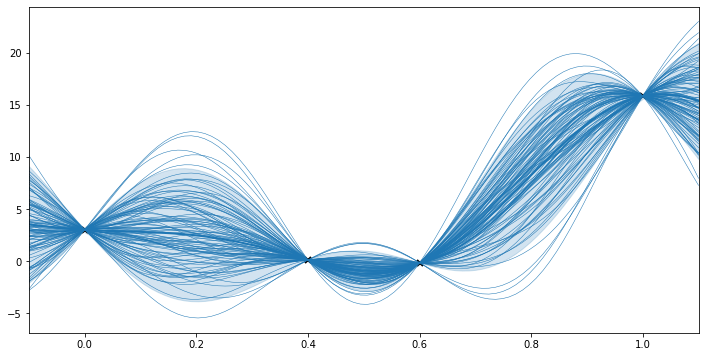

In [101]:
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)


## predict mean and variance of latent GP at test points
mean_e, var_e = model_e.predict_f(xx)


## generate 100 samples from posterior
samples = model_e.predict_f_samples(xx, 100)  # shape (10, 100, 1)

## plot 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_e, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean_e[:,0] - 1.96 * np.sqrt(var_e[:,0]),
                 mean_e[:,0] + 1.96 * np.sqrt(var_e[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);


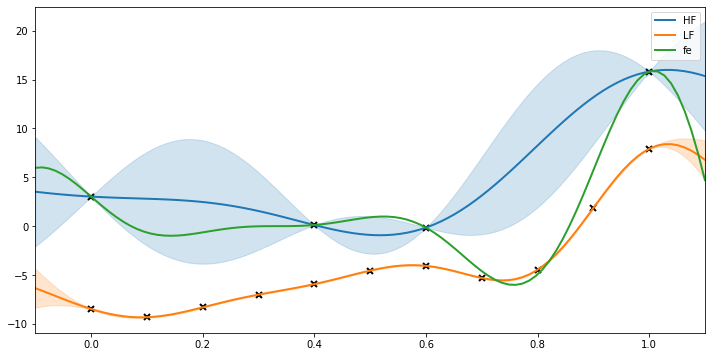

In [102]:

plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(initial_data_c[OBJECTIVE].query_points[:], initial_data_c[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, mean_e, 'C0', lw=2, label="HF")
plt.plot(xx, mean_c, 'C1', lw=2, label="LF")
plt.plot(xx, fe(xx), 'C2', lw=2, label="fe")

plt.fill_between(xx[:,0],
                 mean_e[:,0] - 1.96 * np.sqrt(var_e[:,0]),
                 mean_e[:,0] + 1.96 * np.sqrt(var_e[:,0]),
                 color='C0', alpha=0.2)
plt.fill_between(xx[:,0],
                 mean_c[:,0] - 1.96 * np.sqrt(var_c[:,0]),
                 mean_c[:,0] + 1.96 * np.sqrt(var_c[:,0]),
                 color='C1', alpha=0.2)


plt.xlim(-0.1, 1.1);
plt.legend()

# Building the Multi-fidelity surrogate

In [103]:
X_e=initial_data_e[OBJECTIVE].query_points[:]
Y_e=initial_data_e[OBJECTIVE].observations[:]
Y_c,var_c=model_c.predict_f(X_e)
n=num_initial_points_e


In [105]:
### Building the log-likelihood function
###par=[Ro,l,sigma_square,theta2,noise_variance]
import math
def neg_log_likelihood(par, X_e,Y_e,Y_c):
    Ro,l,var,theta, sigma_epsilon=par 
    dist_X_e = (X_e - X_e.T)**2
    k = var*np.exp(-(1/(2*(l**2)))*dist_X_e)+theta
    n=len(X_e)
    return -(-n/2*np.log(2*np.pi)-1/2*np.log(np.linalg.det(k+(sigma_epsilon**2)*np.eye(n)))-1/2*np.dot(np.dot(( Y_e.numpy()-Ro*Y_c.numpy()).T,np.linalg.inv(k+(sigma_epsilon**2)*np.eye(n))),(Y_e.numpy()-Ro*Y_c.numpy())))




In [106]:
from scipy.optimize import minimize
## we initilized the variance with the value found for the low fidelity GP
start =  [0.1,0.1, 33,0.1,0.1]

min=minimize(neg_log_likelihood, start, args=(X_e,Y_e,Y_c), bounds=[(-np.inf,np.inf),(0e-4,2),(0,30**2),(-np.inf,np.inf),(0,1000)],method='L-BFGS-B',options = {'disp':True,'maxiter':1000})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43090D+01    |proj g|=  2.48351D+00

At iterate    1    f=  1.24241D+01    |proj g|=  1.33098D+00

At iterate    2    f=  1.23829D+01    |proj g|=  1.39246D+00

At iterate    3    f=  1.21868D+01    |proj g|=  3.82600D-01

At iterate    4    f=  1.21632D+01    |proj g|=  6.89804D-01

At iterate    5    f=  1.21486D+01    |proj g|=  3.93582D-01

At iterate    6    f=  1.21342D+01    |proj g|=  4.90384D-01

At iterate    7    f=  1.21319D+01    |proj g|=  3.05431D-01

At iterate    8    f=  1.21285D+01    |proj g|=  1.22782D-01

At iterate    9    f=  1.21265D+01    |proj g|=  2.35733D-01

At iterate   10    f=  1.21082D+01    |proj g|=  9.56148D-01

At iterate   11    f=  1.20736D+01    |proj g|=  1.48615D+00

At iterate   12    f=  1.19776D+01    |proj g|=  1.50492D+00

At iterate   13    f=  1.1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   37    f=  8.61527D+00    |proj g|=  1.01536D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     83     38     0     1   1.015D-02   8.615D+00
  F =   8.6152671368072120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [74]:

min.x
##Ro,l, variance, theta,  noise-variance 

array([  1.918152  ,   1.94070237, 257.66557168, 383.09686288,
         0.        ])

In [107]:
## Now we build the the kernel for Delta_Y=Y_e-Ro*Y_c
k=gpflow.kernels.RBF(min.x[2],min.x[1])
theta=gpflow.kernels.Constant(min.x[3])
k_MF=k+theta


In [108]:
k_MF

<gpflow.kernels.base.Sum object at 0x7f7cc4c47250>
╒═════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                        │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ Sum.kernels[0].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 257.666  │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[0].lengthscales │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │   1.9407 │
├─────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ Sum.kernels[1].variance     │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 383.097  │
╘═════════════════════════════╧═══════════╧═════════════╧═════════╧═════════════╧═════════╧═════════╧══════════╛

In [111]:
## noise_variance

sigma_epsilon=min.x[4]


## correlation vector

def K(x):
    l=len(x)
    K=np.zeros((n,l))
    for i in range(n):
        K[i,:]=k_MF(x,initial_data_e[OBJECTIVE].query_points[i])
    return K
## correlation coefficient
def k(x):
    l=len(x)
    k=np.zeros((1,l))
    k[:]=np.array(k_MF(x)).diagonal()
    return k


## the mean of the MF_surrogate
def f_hat(x) :
    
    Y_e=initial_data_e[OBJECTIVE].observations[:]
    Y_c,var=model_c.predict_f(X_e)
    mean_c, var_c= model_c.predict_f(x)
    
    return min.x[0]*mean_c+np.dot(np.dot(K(x).T, np.linalg.inv(k_MF(X_e)+(sigma_epsilon**2)*np.eye(n))),Y_e-min.x[0]*Y_c)
## the variance of the MF_surrogate
def sigma_square_hat(x):
    mean_c, var_c= model_c.predict_f(x)
    
    
    return pow(min.x[0],2)*var_c+sigma_epsilon**2+k(x).reshape(len(x),1)-np.dot(np.dot(K(x).T, np.linalg.inv(k_MF(X_e)+(sigma_epsilon**2)*np.eye(n))),K(x)).diagonal().reshape(len(x),1)
                                 
                                 

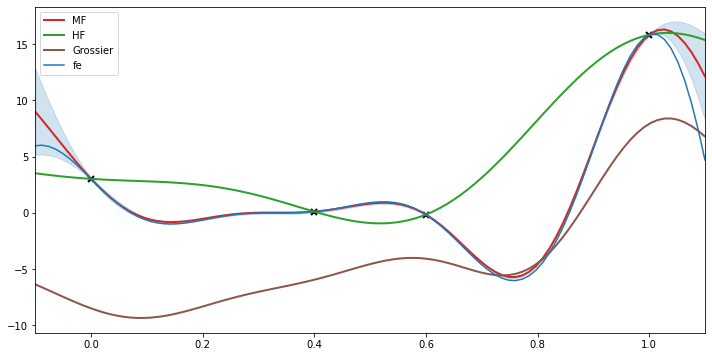

In [112]:

## plotting the curves 
plt.figure(figsize=(12, 6))
plt.plot(initial_data_e[OBJECTIVE].query_points[:], initial_data_e[OBJECTIVE].observations[:], 'kx', mew=2)
plt.plot(xx, f_hat(xx), 'C3', label='MF',lw=2)
plt.plot(xx, mean_e, 'C2', label='HF',lw=2)
plt.plot(xx, mean_c, 'C5', label='Grossier',lw=2)
plt.plot(xx,fe(xx),'C0', label="fe")

plt.fill_between(xx[:,0],
                f_hat(xx)[:,0] - 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                f_hat(xx)[:,0] + 1.96 * np.sqrt(sigma_square_hat(xx)[:,0]),
                color='C0', alpha=0.2)

plt.legend()

plt.xlim(-0.1, 1.1);

In [ ]:
## finally we can build a mutli-fidelity GP and do the bayesian optimisation with EGO 

In [113]:
Ro=gpflow.kernels.Constant(min.x[0])

In [114]:
model_MF=gpflow.models.GPR((xx, f_hat(xx)),Ro*k_c+k_MF,noise_variance=1)

In [115]:
model_MF

<gpflow.models.gpr.GPR object at 0x7f7cc4ede2f0>
╒══════════════════════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════╕
│ name                                                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │         value │
╞══════════════════════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════╡
│ GPR.kernel.kernels[0].kernels[0].variance                │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.91815     │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[0].kernels[1].kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  33.9313      │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[0].kernels[1].kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   0.178668    │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[0].kernels[1].kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   5.28083e-06 │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[1].variance                           │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 257.666       │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[1].lengthscales                       │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │   1.9407      │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.kernel.kernels[2].variance                           │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 383.097       │
├──────────────────────────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────┤
│ GPR.likelihood.variance                                  │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │   1           │
╘══════════════════════════════════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═══════════════╛

In [116]:
import trieste
from trieste.models.gpflow import build_gpr, GaussianProcessRegression
model={'OBJECTIVE':GaussianProcessRegression(model_MF),}